# Processing text, extracting and visualising descriptive statistics

In [ ]:
### TO DO:
# 1. investigate benepar constituency parsing issue with certain sentences. (seems to be non-negative values problem 
# with nltk.Trees)
# 2. write the README file regarding general overivew, technicalities, packages and usage
# 3. include file exports for all author visualisations 
# 4. think about trade-offs in storing certain columns as named tuples (e.g. pos word pairs). easier to extract
# information compared to lists in pd columns. but much less readable 
# 5. generalised visualisations function


### Important note on structure of written txt file:
# 1. the files are currently written with "\t" between elements for the same sentence, except named entites where 
# there is a sub-cat of info. these are separated by "\t\t".
# 2. each line (for each sentence) is separated by a "\n"

In [6]:
import os, re, glob, pickle, string, collections
from os import path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pg_dataextraction import GutenbergCorpusBuilder, Author
import utils_loaddataframe, utils_tokeniser, utils_statsgenerator

### 0. Load the data

##### Load the entire set of author-book-sentence attributes we have collected 

In [7]:
corpus_authorbook_df = utils_loaddataframe.loaddataframe()
corpus_authorbook_df.head(2)

,authorabstracts,authorname,literarymovements,wiki_info,booknum,selected_sents,authornum,filename,booktitle
0,"{'en': 'Christian Nephi Anderson (January 22, ...",Anderson Nephi,[lds fiction],{'en': 'http://en.wikipedia.org/wiki/Nephi_And...,16534,[When did Joseph visit Jackson county the seco...,a4501,./data/booksample_txt/a4501_16534.txt,A Young Folks' History of the Church of Jesus ...
1,"{'en': 'Christian Nephi Anderson (January 22, ...",Anderson Nephi,[lds fiction],{'en': 'http://en.wikipedia.org/wiki/Nephi_And...,17249,[It has been revealed to and tried by men in v...,a4501,./data/booksample_txt/a4501_17249.txt,Added Upon\rA Story (English) (as Author)


##### Extract the literary movements for the authors

In [8]:
# slice the df to include only authorabstracts and authornum
authormovements_df = corpus_authorbook_df[["literarymovements", "authornum"]]
# we have duplicate rows based on authornums, let's drop them
authormovements_df.drop_duplicates("authornum", inplace=True)
authormovements_df.set_index(["authornum"], drop=True, inplace=True)
authormovements_df.head(2)

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,literarymovements
authornum,
a4501,[lds fiction]
a25203,"[historical fiction, time travel, science fict..."


In [9]:
# let's export this for use in Part 3
authormovements_df.to_pickle("./processeddata/df_pickle_movements/movements_df.pickle")

##### Extract the set of English wikipedia extracts for authors

In [10]:
# slice the df to include only authorabstracts and authornum
authorabstracts_df = corpus_authorbook_df[["authorabstracts", "authornum"]]
# we have duplicate rows based on authornums, let's drop them
authorabstracts_df.drop_duplicates("authornum", inplace=True)
authorabstracts_df.set_index(["authornum"], drop=True, inplace=True)
authorabstracts_df.head(2)

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,authorabstracts
authornum,
a4501,"{'en': 'Christian Nephi Anderson (January 22, ..."
a25203,"{'en': 'Poul William Anderson (November 25, 19..."


### 1. Preprocessing and Feature Engineering

##### Running the feature generators on authors' sentences

In [3]:
# set variable values - for functions below
SENT_PER_INST = 1
WRITE_PATH = "./processeddata/"

# get all the authornums
data_filenames = glob.glob("./data/booksample_txt/*.txt")
authornums = set([filename.split("/")[-1].split("_")[0] for filename in data_filenames])

# check if they have been processed before. if so do not re-run process_one_author

done_filenames = glob.glob("./processeddata/df_pickles/{}*.pickle".format(str(SENT_PER_INST)+"sent/"))
done_authornums = set([filename.split("/")[-1].split("_")[0] for filename in done_filenames])

# list comp to remove authornums that have been processed (i.e. have a df_pickle file)
_ = [authornums.remove(i) for i in done_authornums]

##### Run process_one_author #####

# define the postags and parsetags required by the 
select_parsetags = ["NP", "VP"]
select_postags = ["NOUN", 'VERB', 'ADJ', "ADV", "AUX", "INTJ", "NUM", "PRON", "PROPN", "PUNCT"]

for authornum in authornums: 
    __data = utils_tokeniser.process_one_author(authornum, sent_per_inst=SENT_PER_INST,
                                                functions=[utils_tokeniser.get_sentence,utils_tokeniser.get_tokens,
                                               utils_tokeniser.get_lemmas,utils_tokeniser.get_postags,
                                               utils_tokeniser.get_poswordpairs, utils_tokeniser.get_namedentities,
                                               utils_tokeniser.get_parsetags,utils_tokeniser.get_concreteness],
                                               overwrite_files=True, 
                                                write_path=WRITE_PATH+"data_rawtxt/")
    # generate the dataframes containing information about each author, with each row as an instance (in this case, 
    # a sentence from one of the author's books)
    __data_df = utils_tokeniser.generate_dataframe(authornum, __data)
    if not os.path.exists(WRITE_PATH+"df_pickles/{}".format(str(SENT_PER_INST)+"_sent/")):
        os.makedirs(WRITE_PATH+"df_pickles/{}".format(str(SENT_PER_INST)+"_sent/"))
    __data_df.to_pickle(WRITE_PATH+"df_pickles/{}{}_df.pickle".format(str(SENT_PER_INST)+"_sent/", authornum))

##### Running the feature generators on authors' wiki abstracts

In [11]:
authorabstracts_df["namedentities"] =  authorabstracts_df["authorabstracts"].apply(lambda x: utils_tokeniser.get_namedentities(utils_tokeniser.create_spacysentdoc(
x["en"]))[1])
authorabstracts_df.head(2)                                                                   

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,authorabstracts,namedentities
authornum,,
a4501,"{'en': 'Christian Nephi Anderson (January 22, ...","{'places': [], 'persons': ['Nephi Anderson'], ..."
a25203,"{'en': 'Poul William Anderson (November 25, 19...","{'places': [], 'persons': ['Poul William Ander..."


In [13]:
all_sent = []
for sentence_num in authorabstracts_df.index:
    one_sent={}
    col_names = [ne_type for ne_type in authorabstracts_df["namedentities"][sentence_num]]
    ne_dict = {ne_type:[] for ne_type in col_names}
    for col_name in col_names:
        ne_dict[col_name] = authorabstracts_df["namedentities"][sentence_num][col_name]
    for key2 in ne_dict:
        one_sent["ne_wiki"+key2] = ne_dict[key2]
    all_sent.append(one_sent)
    
    
authorabstracts_NE_df= pd.DataFrame(all_sent, index = authorabstracts_df.index)
authorabstracts_NE_df.head(2)

,ne_wikidates,ne_wikipersons,ne_wikiplaces
authornum,,,
a4501,"[January 22, 1865 – January 6, 1923]",[Nephi Anderson],[]
a25203,"[November 25, 1926 – July 31, 2001, the 1940s,...","[Poul William Anderson, Anderson]",[]


##### Cleaning up the named entities obtained from the authors' wiki abstracts

In [14]:
# tokenise NE dates, remove months and numbers
# 1. join all NEs in to a single string. (it was initially a set). objective is to easily tokensise all the ne dates 
# at one go. 
authorabstracts_NE_df["ne_wikidates"] = authorabstracts_NE_df["ne_wikidates"].apply(lambda x: " ".join(x))
authorabstracts_NE_df["ne_wikidates"].head(2)

authornum
a4501                    January 22, 1865 – January 6, 1923
a25203    November 25, 1926 – July 31, 2001 the 1940s th...
Name: ne_wikidates, dtype: object

In [15]:
# 2. tokenise the entire ne date string
authorabstracts_NE_df["ne_wikidates"]= authorabstracts_NE_df["ne_wikidates"].apply(lambda x: utils_tokeniser.get_tokens(utils_tokeniser.create_spacysentdoc(x))[1])
authorabstracts_NE_df["ne_wikidates"].head(2)

authornum
a4501                 [january, 22, 1865, january, 6, 1923]
a25203    [november, 25, 1926, july, 31, 2001, the, 1940...
Name: ne_wikidates, dtype: object

In [16]:
# extract only ne date tokens that are exactly 4-digit numeric (corresponding to years)
authorabstracts_NE_df["ne_wikidates"] = authorabstracts_NE_df["ne_wikidates"].apply(lambda x: [i for i in x if re.match(r'[1-9]{4}$' , i) ] )
authorabstracts_NE_df["ne_wikidates"].head(2)

authornum
a4501     [1865, 1923]
a25203          [1926]
Name: ne_wikidates, dtype: object

In [17]:
# round the dates up to decades, so that we don't have a sparsity problem from vectorisation
authorabstracts_NE_df["ne_wikidates"] = authorabstracts_NE_df["ne_wikidates"].apply(lambda x: [round(int(i),-1) for i in x] )
authorabstracts_NE_df["ne_wikidates"].head(2)

authornum
a4501     [1860, 1920]
a25203          [1930]
Name: ne_wikidates, dtype: object

In [18]:
# export to pickle 
authorabstracts_NE_df.to_pickle("./processeddata/df_pickle_abstracts/authors_abstract_nes.pickle")

#### Generate a toy dataset for a narrow EDA into subcorpuses

In [19]:
# call utils_tokeniser.process_one_author on 2 authors to generate a toy dataset
a4501 = utils_tokeniser.process_one_author("a4501", sent_per_inst=5, functions=[utils_tokeniser.get_sentence,utils_tokeniser.get_tokens,
                                               utils_tokeniser.get_lemmas,utils_tokeniser.get_postags,
                                               utils_tokeniser.get_poswordpairs, utils_tokeniser.get_namedentities,
                                               utils_tokeniser.get_parsetags,utils_tokeniser.get_concreteness],
                                               overwrite_files=True,
                                              write_path=WRITE_PATH+"data_rawtxt/{}_sent/".format(str(SENT_PER_INST)))

a206 = utils_tokeniser.process_one_author("a206", sent_per_inst=5, functions=[utils_tokeniser.get_sentence,utils_tokeniser.get_tokens,
                                               utils_tokeniser.get_lemmas,utils_tokeniser.get_postags,
                                               utils_tokeniser.get_poswordpairs, utils_tokeniser.get_namedentities,
                                               utils_tokeniser.get_parsetags,utils_tokeniser.get_concreteness],
                                               overwrite_files=True,
                                             write_path=WRITE_PATH+"data_rawtxt/{}_sent/".format(str(SENT_PER_INST)))

# Generating a dataframe with all the feature generators
# for the purpose of this exercise, store the results in an iterable dict
select_parsetags = ["NP", "VP"]
select_postags = ["NOUN", 'VERB', 'ADJ', "ADV", "AUX", "INTJ", "NUM", "PRON", "PROPN", "PUNCT"]

a4501_df = utils_tokeniser.generate_dataframe("a4501", a4501, select_postags, select_parsetags)
a4501_df.head(2)    

a206_df = utils_tokeniser.generate_dataframe("a206", a206, select_postags, select_parsetags)
a206_df.head(2)

author_dfs_x2 = {"a4501":a4501_df, "a206": a206_df}

### 2. Descriptive statistics

##### 2a. Vocabulary size - author 

In [20]:
vocab_dict = {}
for author_dfs_x2_key in author_dfs_x2:
    vocab = set()
    for sent in author_dfs_x2[author_dfs_x2_key]["tokens"]:
        vocab.update(sent)
    vocab_dict[ author_dfs_x2_key]=len(vocab)
    print("We have a vocabulary size of {} for the author {}".format(len(vocab),author_dfs_x2_key, ))

We have a vocabulary size of 1186 for the author a4501
We have a vocabulary size of 1251 for the author a206


##### 2b. Max, min, average sentence length

In [21]:
maxminavg_dict = {}
inst_per_sent = 5
for author_dfs_x2_key in author_dfs_x2:
    maxminavg = [max(author_dfs_x2[author_dfs_x2_key]["sent_length"])/inst_per_sent, 
                 min(author_dfs_x2[author_dfs_x2_key]["sent_length"])/inst_per_sent, 
                 sum(author_dfs_x2[author_dfs_x2_key]["sent_length"])/inst_per_sent/len(a4501_df)]
    maxminavg_dict[author_dfs_x2_key] = maxminavg
    print("sentence_lengths for author {} | _max_: {}, _min_: {}, _avg_: {}".format(author_dfs_x2_key,
                                                                              maxminavg[0],maxminavg[1],
                                                                              maxminavg[2]))

sentence_lengths for author a4501 | _max_: 25.2, _min_: 6.6, _avg_: 13.991836734693878
sentence_lengths for author a206 | _max_: 32.6, _min_: 1.0, _avg_: 11.918367346938776


##### 2c. POS distribution

In [22]:
for author_dfs_x2_key in author_dfs_x2:
    pos_dist = author_dfs_x2[author_dfs_x2_key][["pos_"+postag for postag in select_postags]].sum()
    pos_dist.sort_values(inplace=True)
    print("POS tag distribution for {}".format(author_dfs_x2_key), "\n", pos_dist, "\n\n")

POS tag distribution for a4501 
 pos_AUX        0
pos_INTJ      10
pos_NUM       39
pos_PROPN    190
pos_PRON     234
pos_ADV      241
pos_ADJ      294
pos_PUNCT    517
pos_NOUN     603
pos_VERB     713
dtype: int64 


POS tag distribution for a206 
 pos_AUX        0
pos_INTJ       7
pos_NUM       27
pos_ADV      134
pos_PRON     153
pos_PROPN    236
pos_ADJ      266
pos_PUNCT    540
pos_VERB     547
pos_NOUN     574
dtype: int64 




##### 2d. Most frequent named entities

In [23]:
# max length of sentences
NERs = list()
for sent in a206["namedentities"]:
    for type_ in sent:
        NERs.extend(sent[type_])
collections.Counter(NERs).most_common(10)

[('Farquhar', 4),
 ('Farmer', 3),
 ('Lion', 2),
 ('Ambrose Bierce', 2),
 ('Alabama', 1),
 ('a month ago', 1),
 ('Proboscidae', 1),
 ('Cock', 1),
 ('Ferryman', 1),
 ('the King of the FlySpeck Islands', 1)]

##### 2e. Min, max, average NPs and VPs per sentence

The following statistics are for author a4501, Anderson, Nephi https://www.gutenberg.org/ebooks/author/4501 ,

In [24]:
maxminavg = [max(a4501_df["parse_NP"])/inst_per_sent, min(a4501_df["parse_NP"])/inst_per_sent, 
             sum(a4501_df["parse_NP"])/len(a4501_df)/inst_per_sent]
print("NP counts | max: {}, min: {}, avg: {}".format(maxminavg[0],maxminavg[1], maxminavg[2]))

NP counts | max: 9.8, min: 2.2, avg: 4.9346938775510205


In [25]:
maxminavg = [max(a4501_df["parse_VP"])/inst_per_sent, min(a4501_df["parse_VP"])/inst_per_sent, 
             sum(a4501_df["parse_VP"])/len(a4501_df)/inst_per_sent]
print("VP counts | max: {}, min: {}, avg: {}".format(maxminavg[0],maxminavg[1], maxminavg[2]))

VP counts | max: 6.0, min: 0.4, avg: 2.8


___Some analysis of the constituency patterns of the author___

In [26]:
# Let's take a look at the sentences with the longest NP and VP counts
VP_count = 13
for index in a4501_df[a4501_df["parse_VP"]==VP_count].index:
    print(a4501_df[a4501_df["parse_VP"]==VP_count]["sentences"][index])

I did not know she was in town."."Thank you," and he bowed as he gave the signal to begin again..Existence is eternal, and its various stages grade naturally into one another, like the different departments of a school.".They were already within the outskirts of the city.."Yes, you are right.
I just seemed to be waiting" "Yes?".How could such serious schemes brood behind such laughing lips and sparkling eyes?.I may not call you king of Polandthere is but one King on this earthbut I will call you servants of the King, as we all are.."Two of the faces are familiar," remarked Remand, "but the third is strange.."Even a child is known by his doings."Prov.


In [27]:
NP_count = 22
for index in a4501_df[a4501_df["parse_NP"]==VP_count].index:
    print(a4501_df[a4501_df["parse_NP"]==VP_count]["sentences"][index])

Priesthood..3..The brethren were then marched into the camp of the mobmilitia where they were received with great shouts, curses, and yells..Wishing to know more about this new revelation of God, he had sought out Joseph..Questions and Review.1.


### 3. Visualisations

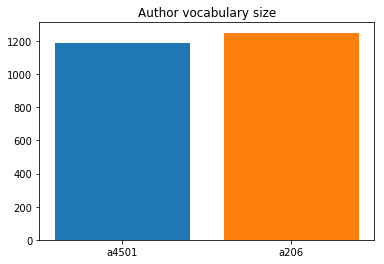

In [28]:
utils_statsgenerator._vocab_barplot(vocab_dict)

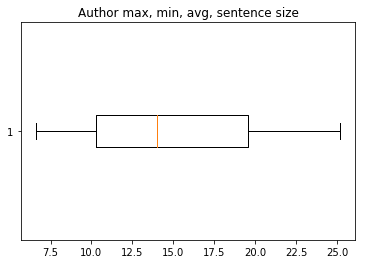

In [29]:
utils_statsgenerator._sentsize_boxplot(maxminavg_dict["a4501"])

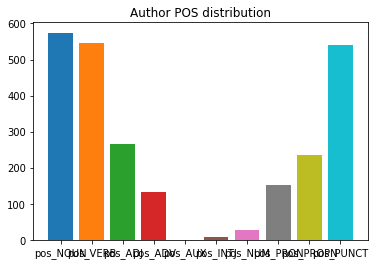

In [30]:
utils_statsgenerator._posdistributions(pos_dist,select_postags)

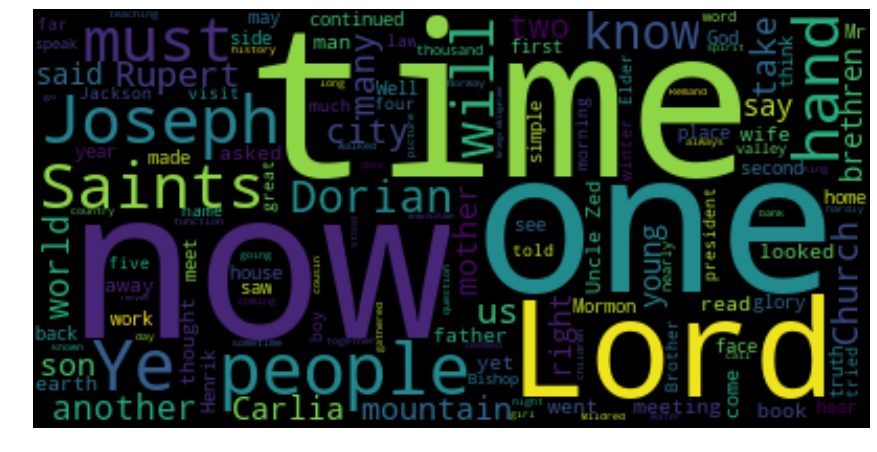

In [31]:
utils_statsgenerator._makecloud(a4501_df["sentences"].sum())